# Electricity Power Market playbook

<p>
Mal Minhas, v0.1<br>
18.08.24
</p>
<p>
<h4>Versions</h4>
<ul>
<li><b>v0.1</b>: 18.08.24. First version</li>
</ul>
</p>

### 1. Introduction

A key principle of any **electricity power market** is to seek to meet demand at the lowest cost. So if demand is low, we only use cheap generators.  With higher demand, one by one the more expensive generators are added.  In this way, the supply function of electricity is created as illustrated below.  On the X axis is the capacity of the power plants, on the Y axis is their variable generation cost.  The supply function is a step function; each step represents the capacity and the variable costs of a power plant.  The way in which the generators are ranked in the supply function, from low to high variable operating costs, is also called the **merit order** of generation.

<div>
<img src="meritOrder.png" width="600"/>
</div>

Power plants have two types of costs:
* **Fixed Costs**: these are the costs you have to pay independent of how much your plant is producing. e.g. capital costs, fixed operating maintenance costs and wages.
* **Variable costs**: these are the costs that are calculated per unit of output.  e.g. costs of the fuel and the costs of the CO2 emissions, if applicable.

You should ONLY consider variable costs when you decide whether to operate the plant because when the price is higher than your variable costs you have a positive net cash flow. This may seem counter-intuitive but whether or not your fixed costs are high are irrelevant to the decision whether or not to run your plant.  You should always run your plant when 
When you have a positive cash flow, this will help to pay off these fixed costs.  Whether this is enough to cover them totally in the long run does not matter now: any positive cashflow from operating your plant is better than none, given that you need to make your fixed cost payments anyway.  A related concept is that of **marginal cost**: this is the cost of producing an additional unit of output.  The marginal cost of a power plant is the cost of producing an additional MWh of electricity.   Sometimes, the terms variable cost and marginal cost are used interchangeably, because for fossil fuel plants they are approximately the same, within the normal operating range of a plant.  Another important concept is **system marginal cost**.  This is the cost of producing one more unit of electricity by the whole market.  It is equal to the variable cost of the most expensive plant that is needed to meet demand.  In other words, the variable cost of the marginal plant.

There is ultimately no certainty that generators will be able to cover their fixed costs: there is investment risk.  If generators do not recover their costs, they will stop investing. Over time, as plants get older and are taken out of service, this leads to scarcity.  Then the market price goes up and investors recover their costs again.

For more detail on merit order and marginal pricing see [this article](https://www.squeaky.energy/blog/understanding-power-markets-merit-order-and-marginal-pricing).

### 2. Power Plant model with Carbon Pricing

Consider a hypothetical electricity market with five power plants: a nuclear power plant, an offshore wind farm, a coal plant, a coal plant with CCS (carbon capture and sequestration) and a natural gas plant with information as shown in the following dataframe:

In [1]:
import pandas as pd

market = {'Plant':['Nuclear Power Plant','Wind Farm','Coal Plant','Coal Plant with CCS','Natural Gas Plant'],
          'Fuel Costs (Euro/MWh)': [20, 0, 18, 22, 40],
          'CO2 emissions [ton/MWh]': [0, 0, 0.9, 0.1, 0.46],
        'Capacity [MW]':[1000, 800, 1000, 600, 500],
}
df = pd.DataFrame(market)
df

,Plant,Fuel Costs (Euro/MWh),CO2 emissions [ton/MWh],Capacity [MW]
0,Nuclear Power Plant,20,0.00,1000
1,Wind Farm,0,0.00,800
2,Coal Plant,18,0.90,1000
3,Coal Plant with CCS,22,0.10,600
4,Natural Gas Plant,40,0.46,500


In the context of this maket, baseload low demand is 1200MW and high demand is 2900MW. 

Let's create a model of the merit order for this market and allow for $CO_2$ pricing to be applied.  In this scenario, the merit order will be determined by two variables only - the `demand` and the `co2_price`:

In [2]:
class PowerPlant:
    def __init__(self, name, fuel_cost, co2_emissions, capacity):
        self.name = name
        self.fuel_cost = fuel_cost
        self.co2_emissions = co2_emissions
        self.capacity = capacity

    def total_cost(self, co2_price):
        return self.fuel_cost + (self.co2_emissions * co2_price)


def calculate_merit_order(demand, co2_price):
    # Define the power plants
    plants = [
        PowerPlant("Nuclear Power Plant", 20, 0, 1000),
        PowerPlant("Wind Farm", 0, 0, 800),
        PowerPlant("Coal Plant", 18, 0.9, 1000),
        PowerPlant("Coal Plant with CCS", 22, 0.1, 600),
        PowerPlant("Natural Gas Plant", 40, 0.46, 500),
    ]

    # Calculate the total cost for each plant
    for plant in plants:
        plant.cost = plant.total_cost(co2_price)

    # Sort the plants by total cost (merit order)
    plants_sorted = sorted(plants, key=lambda p: p.cost)

    # Create the merit order list
    merit_order = []
    total_capacity = 0

    for plant in plants_sorted:
        if total_capacity >= demand:
            break
        merit_order.append((plant.name, plant.cost, min(plant.capacity, demand - total_capacity)))
        total_capacity += plant.capacity

    return merit_order

def display_merit_order(merit_order):
    # Display the merit order
    for plant in merit_order:
        print(f"Plant: {plant[0]}, Cost: {plant[1]:.2f} Euro/MWh, Capacity Used: {plant[2]} MW")
    
def graph_merit_order(merit_order, demand, co2_price):
    # x-axis is the demand so every 2nd element
    x = [x[2] for x in merit_order]
    # y-axis is the price so every 1st element
    y = [x[1] for x in merit_order]
    # label is the name of plant so every 0th element
    names = [x[0] for x in merit_order]
    dfm = pd.DataFrame({'Plant': names, 'Demand (MW)': x, 'Price (Euro/MWh)': y})
    ax = dfm.plot(kind='bar', x='Demand (MW)', y='Price (Euro/MWh)', figsize=(15, 6), legend=False)
    ax.set_title(f'Merit Order of Power Plants at demand={demand}MW and CO2 price=€{co2_price}')
    # Rotate the x-axis labels for better readability
    ax.set_xticklabels(dfm['Demand (MW)'], rotation=0)
    # Annotate each bar with the name of the plant (above the bar)
    for i in range(len(dfm)):
        ax.text(i, y[i] + 0.1, f"{dfm['Plant'][i]} (€{dfm['Price (Euro/MWh)'][i]}/MWh)", ha='center', va='bottom', fontsize=10)

Let's display and then graph the merit order for a low demand scenario when there is no $CO_2$ price.  In this scenario we set `demand` to 1200 and `co2_price` to 0:

Plant: Wind Farm, Cost: 0.00 Euro/MWh, Capacity Used: 800 MW
Plant: Coal Plant, Cost: 18.00 Euro/MWh, Capacity Used: 400 MW


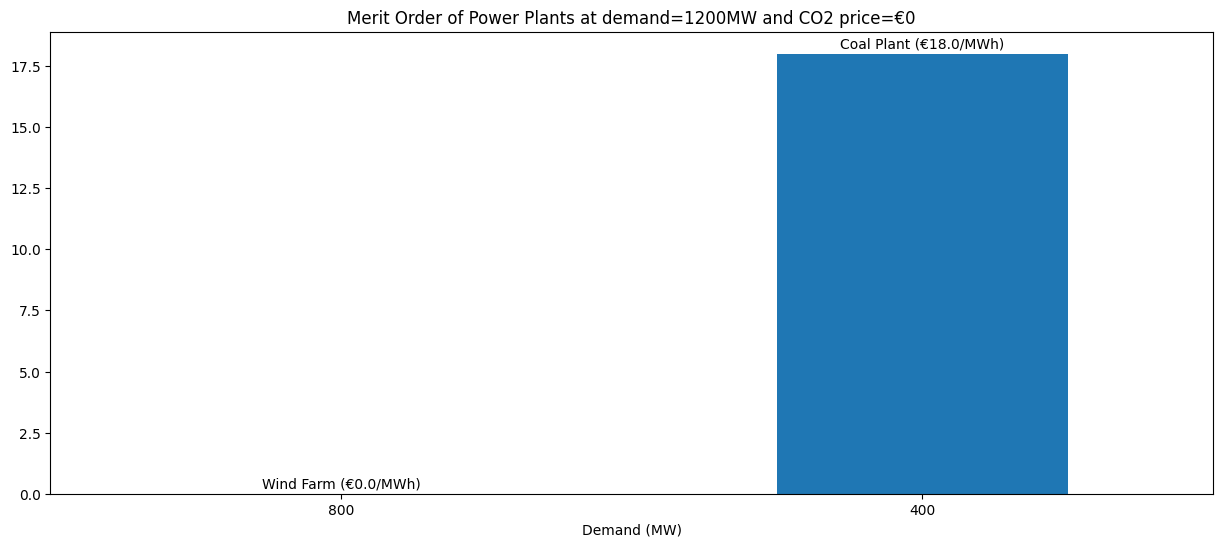

In [3]:
demand = 1200  # MW
co2_price = 0  # Euro/ton
merit_order = calculate_merit_order(demand, co2_price)
display_merit_order(merit_order)
graph_merit_order(merit_order, demand, co2_price)

Now let's display and graph the merit order for a high demand scenario when there is no $CO_2$ price.  In this scenario we set `demand` to 2900 and `co2_price` to 0:

Plant: Wind Farm, Cost: 0.00 Euro/MWh, Capacity Used: 800 MW
Plant: Coal Plant, Cost: 18.00 Euro/MWh, Capacity Used: 1000 MW
Plant: Nuclear Power Plant, Cost: 20.00 Euro/MWh, Capacity Used: 1000 MW
Plant: Coal Plant with CCS, Cost: 22.00 Euro/MWh, Capacity Used: 100 MW


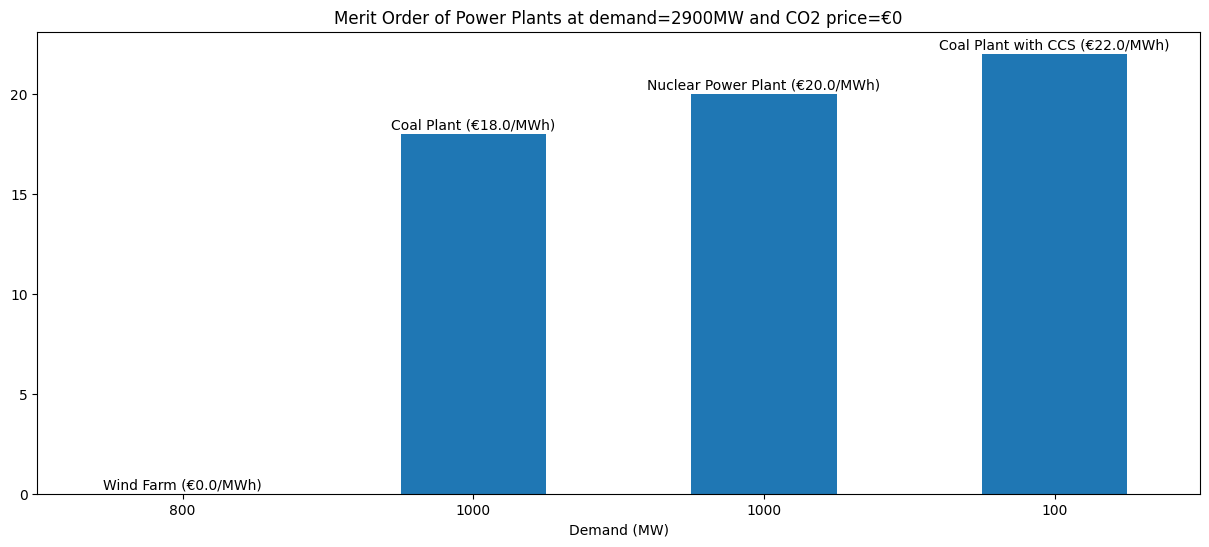

In [4]:
demand = 2900  # MW
co2_price = 0  # Euro/ton
merit_order = calculate_merit_order(demand, co2_price)
display_merit_order(merit_order)
graph_merit_order(merit_order, demand, co2_price)

Let's add in a price of €10/ton of $CO_2$ and see if it changes the merit order:

Plant: Wind Farm, Cost: 0.00 Euro/MWh, Capacity Used: 800 MW
Plant: Nuclear Power Plant, Cost: 20.00 Euro/MWh, Capacity Used: 1000 MW
Plant: Coal Plant with CCS, Cost: 23.00 Euro/MWh, Capacity Used: 600 MW
Plant: Coal Plant, Cost: 27.00 Euro/MWh, Capacity Used: 500 MW


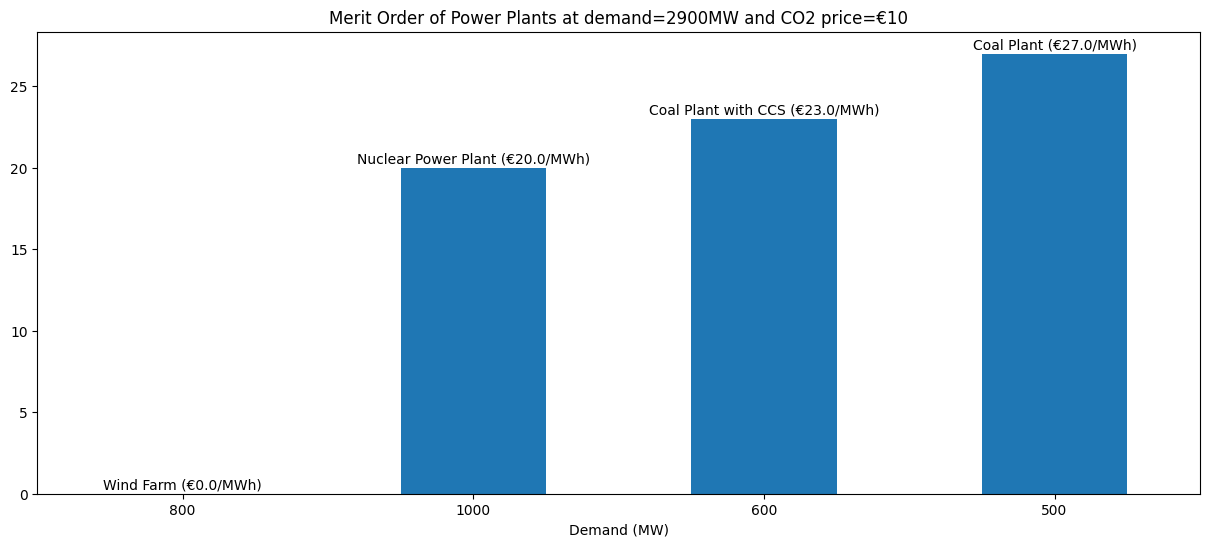

In [5]:
demand = 2900  # MW
co2_price = 10  # Euro/ton
merit_order = calculate_merit_order(demand, co2_price)
display_merit_order(merit_order)
graph_merit_order(merit_order, demand, co2_price)

Indeed it does.  We see that pricing in the cost of carbon at €10/ton means that the coal plant drops to the end of the merit order.  What if we continue to increase the price of $CO_2$?

Plant: Wind Farm, Cost: 0.00 Euro/MWh, Capacity Used: 800 MW
Plant: Nuclear Power Plant, Cost: 20.00 Euro/MWh, Capacity Used: 1000 MW
Plant: Coal Plant with CCS, Cost: 32.00 Euro/MWh, Capacity Used: 600 MW
Plant: Natural Gas Plant, Cost: 86.00 Euro/MWh, Capacity Used: 500 MW


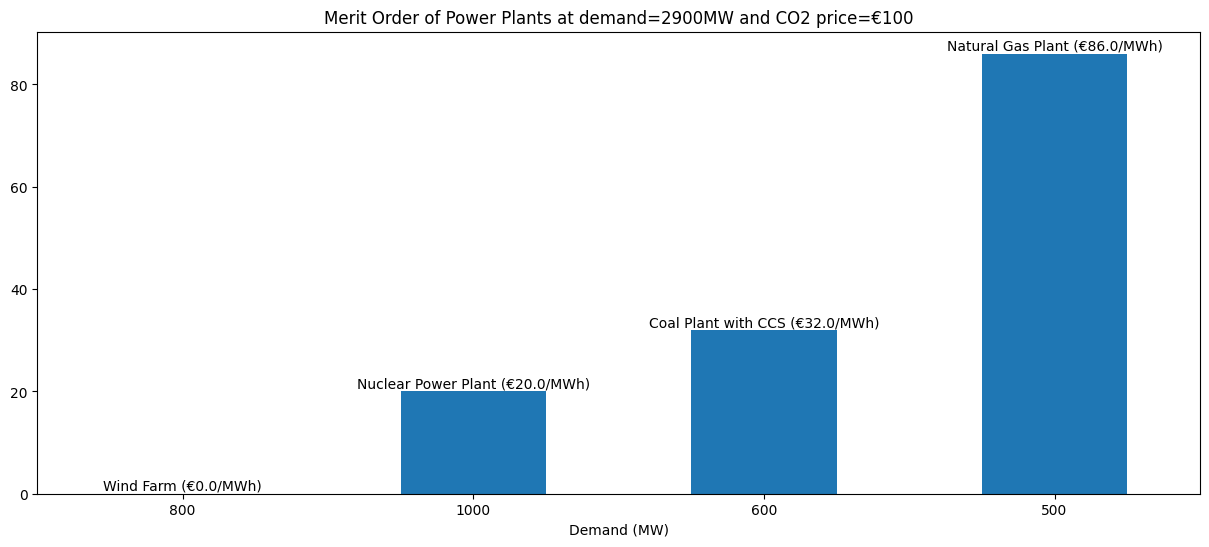

In [6]:
demand = 2900  # MW
co2_price = 100  # Euro/ton
merit_order = calculate_merit_order(demand, co2_price)
display_merit_order(merit_order)
graph_merit_order(merit_order, demand, co2_price)

We see that at a €100/ton, coal is supplanted by the Natural Gas Plant in the merit order.  This is more [broadly reflective of the current UK electricity generation mix](https://grid.iamkate.com/) illustrated below.  However, it should be noted that $CO_2$ price in the UK [has declined to £40/ton](https://www.statista.com/statistics/1322275/carbon-prices-united-kingdom-emission-trading-scheme/) from a peak of over £100/ton two years ago. 

<div>
<img src="electricitySourceMix.png" width="900"/>
</div>